# -*- coding: utf-8 -*-
"""
Created on Sat Feb 19 2022

@author: Ines AGOSSOU, Ines KOUYATE, Nandy MAVUA
@subject: Big Data Tools for Business with Dieudonné TCHUENTE
"""

# **Part 2: Real estate market data Exploration in Toulouse and its suburbs**

### Import the modules 📁

In [4]:
!pip install pyspark_dist_explore

In [1]:
import pyspark
import pyspark.sql.functions as f
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from pyspark_dist_explore import hist

In [6]:
spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-API-RealEstate").getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

### Cleaning 🧹

#### Change the type of the data 

In [7]:
real_estateSchema = StructType ([StructField("SaleDate", DateType(), True),
                                StructField("SaleType", StringType(), True),
                                StructField("Price", IntegerType(), True),
                                StructField("PostCode", StringType(), True),
                                StructField("City", StringType(), True),
                                StructField("NbRooms", IntegerType(), True),
                                StructField("NbLots", IntegerType(), True),
                                StructField("ResidenceType", StringType(), True),
                                StructField("LivingArea", IntegerType(), True),
                                StructField("LandArea", IntegerType(), True)])

In [8]:
real_estate_df = spark.read.csv('project_data_real_estate_toulouse_and_suburbs.csv', sep=';', dateFormat='dd/MM/yyyy', schema=real_estateSchema, header=True)
real_estate_df.show() 

+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|2019-01-15|                SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|2019-01-21|                SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|2019-01-03|                SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|2019-01-11|                SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|2019-01-15|                SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|2019-01-15|                SALE|209300|   31270

In [9]:
real_estate_df.printSchema()

root
 |-- SaleDate: date (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- PostCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)



In [11]:
real_estate_summary_df = real_estate_df['Price', 'NbRooms', 'NbLots', 'LivingArea', 'LandArea'].summary()
real_estate_summary_df.show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|             Price|           NbRooms|            NbLots|       LivingArea|          LandArea|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|             77105|             80118|             80118|            80118|             80118|
|   mean| 552147.5415342714| 3.000099852717242|1.0370453580968073|66.89275818168201|254.02662323073466|
| stddev|2435569.9954218385|1.3511218124829414|0.8291382225291024|35.89520999460289|1369.2367598573933|
|    min|                 0|                 1|                 0|                1|                 0|
|    25%|            122470|                 2|                 0|               43|                 0|
|    50%|            180000|                 3|                 1|               62|                 0|
|    75%|            280000|                 4|                 

#### Remove duplicates ➿

In [12]:
nb_rows = real_estate_df.count()
nb_distinct_rows = real_estate_df.distinct().count()

print('total number of rows: ', nb_rows, 'total number distinct rows: ', nb_distinct_rows)

total number of rows:  80118 total number distinct rows:  71935


In [13]:
real_estate_without_duplicates_df = real_estate_df.dropDuplicates()

print(nb_rows-nb_distinct_rows, 'rows were removed')

8183 rows were removed


In [12]:
#real_estate_summary_without_duplicates_df = real_estate_without_duplicates_df['Price', 'NbRooms', 'NbLots', 'LivingArea', 'LandArea'].summary()
#real_estate_summary_without_duplicates_df.show()

#### Deal with missing values 👀

In [13]:
#{col:real_estate_without_duplicates_df.filter(real_estate_without_duplicates_df[col].isNull()).count() for col in real_estate_without_duplicates_df.columns}

In [14]:
#from pyspark.sql.functions import col,isnan, when, count
check_df = real_estate_without_duplicates_df.drop('SaleDate')

print('Missing values (Nan):')
check_df.select([count(when(isnan(col), col)).alias(col) for col in check_df.columns]).show()

print('Null values:')
check_df.select([count(when(col(c).isNull(), c)).alias(c) for c in check_df.columns]).show()


Missing values (Nan):
+--------+-----+--------+----+-------+------+-------------+----------+--------+
|SaleType|Price|PostCode|City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+--------+-----+--------+----+-------+------+-------------+----------+--------+
|       0|    0|       0|   0|      0|     0|            0|         0|       0|
+--------+-----+--------+----+-------+------+-------------+----------+--------+

Null values:
+--------+-----+--------+----+-------+------+-------------+----------+--------+
|SaleType|Price|PostCode|City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+--------+-----+--------+----+-------+------+-------------+----------+--------+
|       0| 1838|       0|   0|      0|     0|            0|         0|       0|
+--------+-----+--------+----+-------+------+-------------+----------+--------+



In [15]:
real_estate_without_duplicates_df[['Price']].summary("mean").show()

+-------+-----------------+
|summary|            Price|
+-------+-----------------+
|   mean|328783.9234061372|
+-------+-----------------+



In [16]:
# The average price is 328784 as seen through the summary
real_estate_without_null_df = real_estate_without_duplicates_df.fillna(int('328784'),subset=['Price'])

new_check_df = real_estate_without_null_df.drop('SaleDate')

print('Null values after replacing by the mean:')
new_check_df.select([count(when(col(c).isNull(), c)).alias(c) for c in new_check_df.columns]).show()

Null values after replacing by the mean:
+--------+-----+--------+----+-------+------+-------------+----------+--------+
|SaleType|Price|PostCode|City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+--------+-----+--------+----+-------+------+-------------+----------+--------+
|       0|    0|       0|   0|      0|     0|            0|         0|       0|
+--------+-----+--------+----+-------+------+-------------+----------+--------+



In [17]:
#real_estate_summary_df = real_estate_df['Price', 'NbRooms', 'NbLots', 'LivingArea', 'LandArea'].summary()
#real_estate_summary_df.show()

#### Deal with outliers

In [18]:
import seaborn as sns

def boxplot(df, box_title):
    """Plot a boxplot for each numeric column of the dataset."""
    
    n = len(numeric_columns)
    i = 1
    
    
    fig = plt.figure(figsize=(18, 5))
    fig.suptitle(box_title)
    for col in numeric_columns:
        fig.add_subplot(int(f'1{n}{i}'))
        x = df.select(col).toPandas()
        sns.boxplot(data=x)
        i = i + 1

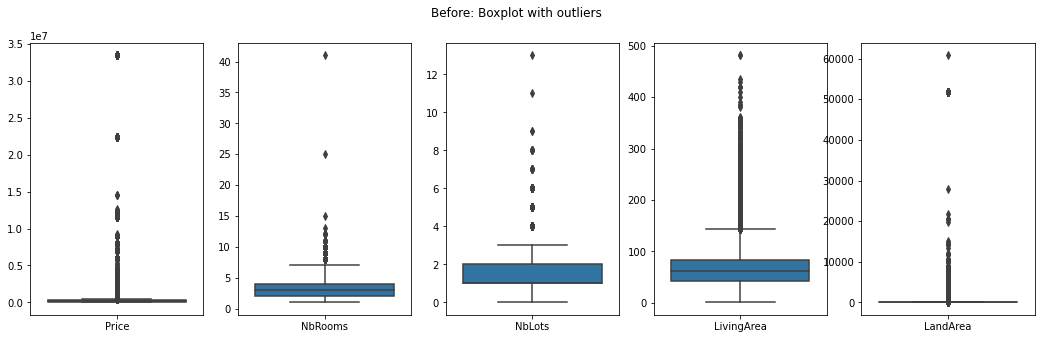

In [19]:
# Identifying the numerical columns and ploting the box-plots

numeric_columns = [column[0] for column in real_estate_without_null_df.dtypes if column[1]=='int']
boxplot(real_estate_without_null_df, 'Before: Boxplot with outliers')
#df[numeric_columns].summary().show()

In [20]:
# Prices are positive figures... But still there are outliers. For example prices below €100:

real_estate_without_null_df.createOrReplaceTempView('real_estate')
real_estate_price_outliers_df = spark.sql(" SELECT *, Price FROM real_estate WHERE Price < 100 ")
real_estate_price_outliers_df.show(5)

+----------+--------------------+-----+--------+--------+-------+------+-------------+----------+--------+-----+
|  SaleDate|            SaleType|Price|PostCode|    City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|Price|
+----------+--------------------+-----+--------+--------+-------+------+-------------+----------+--------+-----+
|2015-03-19|SALE BEFORE COMPL...|    0|   31500|TOULOUSE|      3|     2|    APARTMENT|        63|       0|    0|
|2019-06-06|                SALE|    1|   31240| L UNION|      3|     0|    APARTMENT|        61|       9|    1|
|2018-10-18|                SALE|    1|   31100|TOULOUSE|      2|     0|    APARTMENT|        56|     423|    1|
|2019-06-06|                SALE|    1|   31240| L UNION|      3|     0|    APARTMENT|        59|       9|    1|
|2018-10-18|                SALE|    1|   31100|TOULOUSE|      6|     0|    APARTMENT|       147|     423|    1|
+----------+--------------------+-----+--------+--------+-------+------+-------------+----------

**Observation:** We can see that the price of some residencies is '0' or '1'. This is not possible. So we can say those are outliers, there will be removed.

In [21]:
#Removing price outliers 

col_price = numeric_columns[0]

# Identifying lower and upper price limits to keep 95% of the dataset.
# Since prices are above 0, we'll remove 1% of the lower prices to avoid
# having prices such as €0 or €1.

Q1 = real_estate_without_null_df.approxQuantile(col_price,[0.25],relativeError=0)[0]
Q3 = real_estate_without_null_df.approxQuantile(col_price,[0.75],relativeError=0)[0]
percentile_1 = real_estate_without_null_df.approxQuantile(col_price,[0.01],relativeError=0)[0]

IQR = Q3 - Q1

lower_limit = percentile_1 #Noramlly Q1 - 1.5*IQR but since we work with positive figures we'll keep 0 as min bound for outliers
upper_limit = Q3 + 1.5*IQR

print(f'{col_price} : Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}, lower 1% = {lower_limit}, max = {upper_limit}\n')

real_estate_without_null_df = real_estate_without_null_df.withColumn('Outlier', f.when((real_estate_without_null_df[col_price] > upper_limit) | (real_estate_without_null_df[col_price] < lower_limit), "yes").otherwise("no"))
real_estate_price_outliers_df = real_estate_without_null_df.filter("Outlier == 'yes'").count()
fraction = np.round(real_estate_price_outliers_df/real_estate_without_null_df.count()*100)
print(f'''Regarding the {col_price}, {real_estate_price_outliers_df} outliers will be removed: this represents {fraction}% of the rows.''')

Price : Q1 = 120500.0, Q3 = 274293.0, IQR = 153793.0, lower 1% = 45000.0, max = 504982.5

Regarding the Price, 5740 outliers will be removed: this represents 8.0% of the rows.


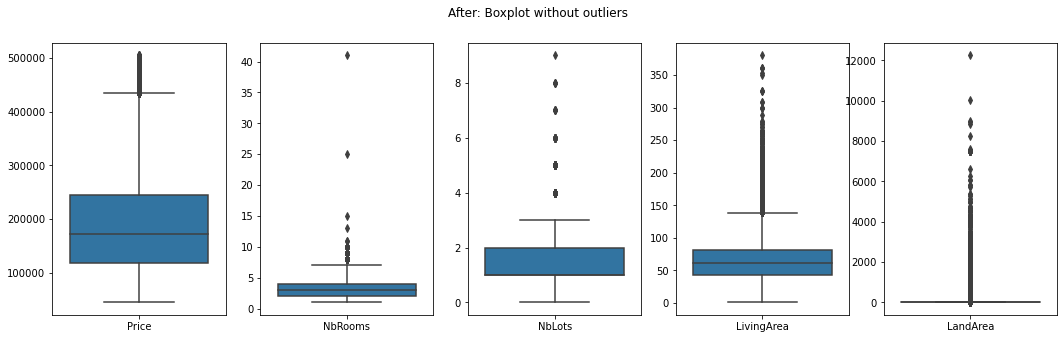

In [22]:
real_estate_without_outliers_df = real_estate_without_null_df.filter("Outlier == 'no'")
boxplot(real_estate_without_outliers_df, 'After: Boxplot without outliers')

In [23]:
clean_real_estate_df = real_estate_without_outliers_df.drop('Outlier')
clean_real_estate_df['Price', 'NbRooms', 'NbLots', 'LivingArea', 'LandArea'].summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|            Price|           NbRooms|            NbLots|        LivingArea|          LandArea|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|            66195|             66195|             66195|             66195|             66195|
|   mean|193456.6582974545|2.9743636226301082|1.1092076440818792| 65.11955585769319|115.18992371025001|
| stddev|97710.79035987232|1.2819650446630886|0.7943657718574154|30.945827264430147| 346.4498381451113|
|    min|            45000|                 1|                 0|                 1|                 0|
|    25%|           119000|                 2|                 1|                43|                 0|
|    50%|           171930|                 3|                 1|                62|                 0|
|    75%|           245000|                 4|                 2

**Observation:** The dataset after the cleaning contains 66,195 rows. 10,910 rows where then removed (outliers, duplicates, null...). 
We can observe that in average, the residences (house, appartments) sold are residences with 3 rooms, 1 lot, 65m² living area and 0m² landing area (median), for an average price of 193,457€.

## Exploration of the data - SQL Queries

#### View the tables

In [24]:
clean_real_estate_df.createOrReplaceTempView('real_estate')

In [25]:
# Select all the data
real_estate_all_df = spark.sql("SELECT * FROM real_estate")
real_estate_all_df.show(10)

+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|2018-06-29|SALE BEFORE COMPL...|285900|   31270|VILLENEUVE TOLOSANE|      4|     1|    APARTMENT|        86|       0|
|2018-07-10|                SALE|274500|   31270|VILLENEUVE TOLOSANE|      9|     0|        HOUSE|       187|     621|
|2018-09-20|                SALE|185650|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        80|     231|
|2017-10-09|                SALE|244900|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     314|
|2017-12-27|                SALE|200000|   31270|VILLENEUVE TOLOSANE|      3|     0|        HOUSE|        63|     494|
|2016-12-23|SALE BEFORE COMPL...|160000|   31270

In [26]:
# Count the rows
# spark.sql("SELECT COUNT(*) AS NbRows FROM real_estate").show()

### Descriptive statistics

In [27]:
real_estate_sales_evolution_df = spark.sql("""SELECT 
                                                SaleDate as sales_date, 
                                                round(count(ResidenceType)) as sales_volume,
                                                round(avg(Price)) as mean_price
                                            FROM real_estate WHERE City != 'TOULOUSE' GROUP BY SaleDate ORDER BY SaleDate""").toPandas()

real_estate_toulouse_sales_evolution_df = spark.sql("""SELECT 
                                                SaleDate as sales_date, 
                                                round(count(ResidenceType)) as sales_volume,
                                                round(avg(Price)) as mean_price
                                            FROM real_estate WHERE City = 'TOULOUSE' GROUP BY SaleDate ORDER BY SaleDate""").toPandas()

In [28]:
real_estate_sales_evolution_df.head()

,sales_date,sales_volume,mean_price
0,2015-01-02,1,117000.0
1,2015-01-04,1,400000.0
2,2015-01-05,9,227327.0
3,2015-01-06,13,237398.0
4,2015-01-07,13,194332.0


In [29]:
def times_series_plot(ax, df, num_col, time_letter, plot_title, color):
    """Resampling the data to plot times series for the choosen period."""
    ax.plot(df.iloc[:, [0, num_col]].set_index('sales_date').resample(time_letter).mean(), color)
    ax.set_title(plot_title)

In [30]:
# Let's make sure 'date' is actually a date in pandas
real_estate_sales_evolution_df["sales_date"] = pd.to_datetime(real_estate_sales_evolution_df["sales_date"])
real_estate_toulouse_sales_evolution_df["sales_date"] = pd.to_datetime(real_estate_toulouse_sales_evolution_df["sales_date"])

In [ ]:
# Plot the daily sales of all cities (not considering Toulouse)

#date = real_estate_sales_evolution_df["sales_date"]
#sales = real_estate_sales_evolution_df["sales_volume"]
#price = real_estate_sales_evolution_df["mean_price"]

# fig, ax = plt.subplots(figsize=(30, 6))
# ax.plot(date, sales)

# Plot the average price evolution (daily)
# fig, ax = plt.subplots(figsize=(30, 6))
# ax.plot(date, price);

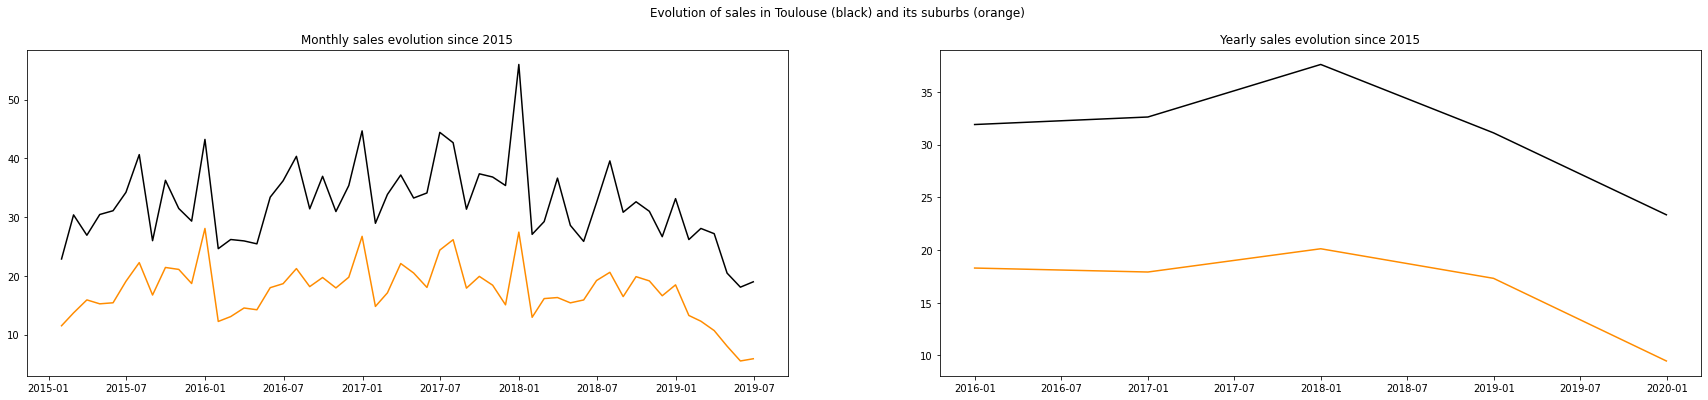

In [31]:
# Sales evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,6))
plt.suptitle('Evolution of sales in Toulouse (black) and its suburbs (orange)')

times_series_plot(ax1, real_estate_sales_evolution_df, 1, 'M', 'Monthly sales evolution since 2015', 'darkorange')
times_series_plot(ax2, real_estate_sales_evolution_df, 1, 'Y', 'Yearly sales evolution since 2015', 'darkorange')

times_series_plot(ax1, real_estate_toulouse_sales_evolution_df, 1, 'M', 'Monthly sales evolution since 2015', 'black')
times_series_plot(ax2, real_estate_toulouse_sales_evolution_df, 1, 'Y', 'Yearly sales evolution since 2015', 'black')

**Observation:** There is seasonality. Indeed, the same pattern seems to repeat itself each year : few sales in the first part of the year, three peaks in march, july and december and a constant increase until the end of the year. However, the overall volumes of sales is decresing since 2018.

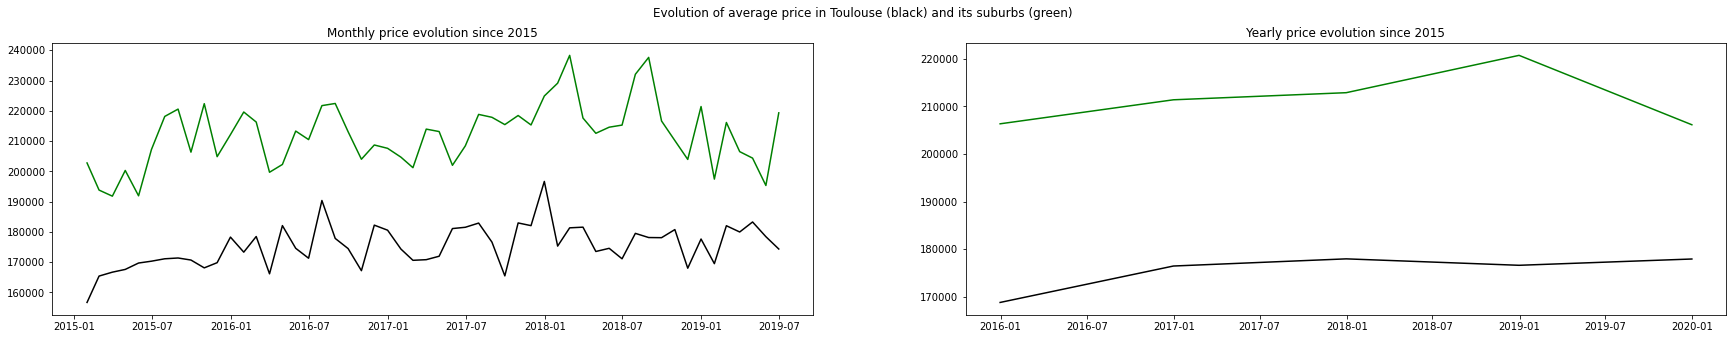

In [32]:
# Price evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,5))
plt.suptitle('Evolution of average price in Toulouse (black) and its suburbs (green)')

times_series_plot(ax1, real_estate_sales_evolution_df, 2, 'M', 'Monthly price evolution since 2015', 'green')
times_series_plot(ax2, real_estate_sales_evolution_df, 2, 'Y', 'Yearly price evolution since 2015', 'green')


times_series_plot(ax1, real_estate_toulouse_sales_evolution_df, 2, 'M', 'Monthly price evolution since 2015', 'black')
times_series_plot(ax2, real_estate_toulouse_sales_evolution_df, 2, 'Y', 'Yearly price evolution since 2015', 'black')

### Quick overview of the cities

In [33]:
# Select distinct city

real_estate_distinct_city_df = real_estate_all_df.select('City').distinct().count()
print(f'There are {real_estate_distinct_city_df} distinct cities.')

There are 26 distinct cities.


In [34]:
# Quick overview of these 26 cities 

# Focus overview : Apartment
real_estate_overview_apartment_df = spark.sql("""SELECT 
                                                    ResidenceType as residence_type,
                                                    City as city,
                                                    CONCAT(CAST(round(avg(Price)) AS VARCHAR(15)), '€') as ap_mean_price,
                                                    CONCAT(CAST(round(avg(Price)/avg(LivingArea)) AS VARCHAR(15)), '€') as ap_mean_m2_price,
                                                    round(count(ResidenceType)) as a_sales_volume,
                                                    round(avg(NbRooms)) as ap_mean_rooms,
                                                    round(avg(NbLots)) as ap_mean_lots,
                                                    round(avg(LivingArea)) as ap_mean_living_area,
                                                    round(avg(LandArea)) as ap_mean_land_area
                                                FROM real_estate 
                                                WHERE ResidenceType = 'APARTMENT'
                                                GROUP BY City, ResidenceType
                                                ORDER BY City""")
# Focus overview : House
real_estate_overview_house_df = spark.sql("""SELECT 
                                                ResidenceType as residence_type,
                                                City as city,
                                                CONCAT(CAST(round(avg(Price)) AS VARCHAR(15)), '€') as h_mean_price,
                                                CONCAT(CAST(round(avg(Price/LivingArea)) AS VARCHAR(15)), '€') as h_mean_m2_price,
                                                round(count(ResidenceType)) as h_sales_volume,
                                                round(avg(NbRooms)) as h_mean_rooms,
                                                round(avg(NbLots)) as h_mean_lots,
                                                round(avg(LivingArea)) as h_mean_living_area,
                                                round(avg(LandArea)) as h_mean_land_area
                                            FROM real_estate 
                                            WHERE ResidenceType = 'HOUSE'
                                            GROUP BY ResidenceType, City
                                            ORDER BY City""")
real_estate_overview_apartment_df = real_estate_overview_apartment_df.toPandas()
real_estate_overview_house_df = real_estate_overview_house_df.toPandas()

In [35]:
# Show them in descending order of average price
pd.concat([real_estate_overview_apartment_df, real_estate_overview_house_df], axis=1).sort_values(by=['ap_mean_price', 'h_mean_price'], ascending=False).reset_index(drop=True)

,residence_type,city,ap_mean_price,ap_mean_m2_price,a_sales_volume,ap_mean_rooms,ap_mean_lots,ap_mean_living_area,ap_mean_land_area,residence_type,city,h_mean_price,h_mean_m2_price,h_sales_volume,h_mean_rooms,h_mean_lots,h_mean_living_area,h_mean_land_area
0,APARTMENT,VIEILLE TOULOUSE,440000.0€,11000.0€,2,2.0,0.0,40.0,870.0,HOUSE,VIEILLE TOULOUSE,372716.0€,2832.0€,43,5.0,0.0,143.0,2034.0
1,APARTMENT,LABEGE,247838.0€,3857.0€,47,3.0,2.0,64.0,95.0,HOUSE,LABEGE,323244.0€,2898.0€,84,4.0,0.0,117.0,709.0
2,APARTMENT,AUZEVILLE-TOLOSANE,209552.0€,3180.0€,102,3.0,2.0,66.0,0.0,HOUSE,AUZEVILLE-TOLOSANE,332080.0€,2835.0€,87,5.0,0.0,122.0,670.0
3,APARTMENT,QUINT-FONSEGRIVES,195697.0€,3368.0€,205,3.0,1.0,58.0,14.0,HOUSE,QUINT-FONSEGRIVES,304841.0€,3063.0€,167,4.0,0.0,104.0,541.0
4,APARTMENT,BALMA,195500.0€,3105.0€,832,3.0,1.0,63.0,18.0,HOUSE,BALMA,340393.0€,3261.0€,365,5.0,0.0,110.0,455.0
5,APARTMENT,L UNION,193358.0€,3485.0€,353,3.0,1.0,55.0,21.0,HOUSE,L UNION,287504.0€,2865.0€,473,5.0,0.0,103.0,535.0
6,APARTMENT,BEAUZELLE,191236.0€,3230.0€,392,3.0,2.0,59.0,14.0,HOUSE,BEAUZELLE,284750.0€,2980.0€,184,4.0,0.0,99.0,563.0
7,APARTMENT,CASTANET TOLOSAN,185947.0€,3173.0€,859,3.0,2.0,59.0,15.0,HOUSE,CASTANET TOLOSAN,307328.0€,2829.0€,295,5.0,0.0,114.0,651.0
8,APARTMENT,TOURNEFEUILLE,185531.0€,3402.0€,1273,3.0,2.0,55.0,6.0,HOUSE,TOURNEFEUILLE,318236.0€,3009.0€,886,5.0,0.0,109.0,585.0
9,APARTMENT,SAINT-JEAN,183268.0€,3314.0€,557,3.0,1.0,55.0,59.0,HOUSE,SAINT-JEAN,277069.0€,2741.0€,458,5.0,0.0,103.0,441.0


**Observations:**
* We can quickly notice that appartments in **VIEILLE TOULOUSE** are sold at the highest price (11.000€/m²), although this city sells the lower number of apartments (i.e. 2 apartments). Indeed the inhabitants of this city are more likely to buy houses there, that may be why the apartments are sold with an expennsive price, in order for the real estate companies to make profit.
* In the contrary, the less expensive residences are located in **AUCAMVILLE** (2354€/m² for apartments and 2582€/m² for houses), although they are sold in high volume  compared to other cities (610 apartments and 300 houses.) 
* **TOULOUSE** is the city with the highest number of sales in our dataset (38347 apartments and 4859 houses sold).


### Quick overview whithout the distinction of Residence type

In [36]:
# Average property price per city (downward price without making a distinction of ReisidenceType)
#print('Top 5 most expensive cities:')
real_estate_avg_bottom_df = spark.sql("SELECT City, ROUND(avg(Price),2) as mean_price FROM real_estate GROUP BY City ORDER BY mean_price desc ")
#real_estate_avg_bottom_df.show(5)

# Average property price per city (rising price without making a distinction of ReisidenceType)
#print('Top 5 less expensive cities:')
real_estate_avg_top_df = spark.sql("SELECT City, ROUND(avg(Price),2) as mean_price FROM real_estate GROUP BY City ORDER BY mean_price asc ")
#real_estate_avg_top_df.show(5)

In [37]:
# Visualization 
df_pandas_top_city = real_estate_avg_top_df.toPandas()[0:5]
#df_pandas_top_city

df_pandas_bottom_city = real_estate_avg_bottom_df.toPandas()[0:5]
#df_pandas_bottom_city

df_concat =  pd.concat([df_pandas_top_city, df_pandas_bottom_city]).sort_values(ascending=False, by = ['mean_price']).reset_index(drop=True)
df_concat

df_concat.loc[0:3, ['color']] = 'green'
df_concat.loc[3:7, ['color']] = 'gainsboro'
df_concat.loc[7:9, ['color']] = 'red'
#real_estate_avg_top_df.show(5).toPandas.plot.bar()  

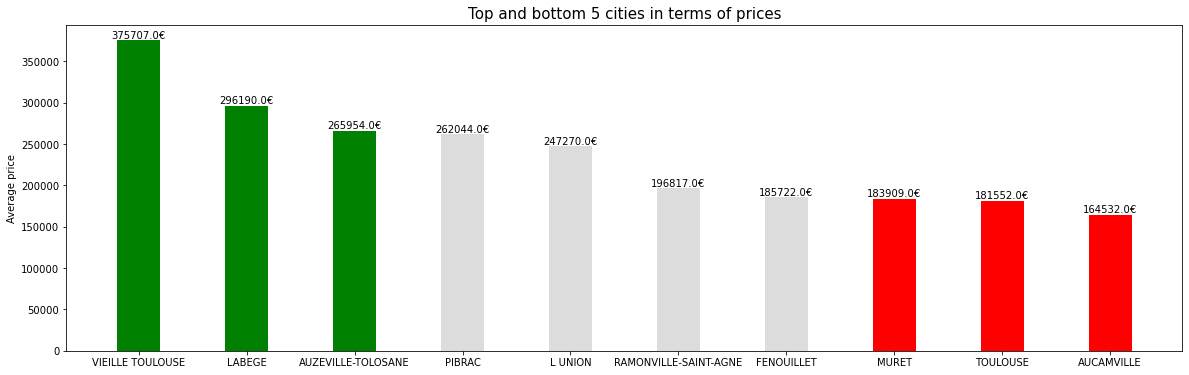

In [38]:
city = df_concat.City
values = df_concat.mean_price.round()
  
fig = plt.figure(figsize = (20, 6))
 
# creating the bar plot
plt.bar(city, values, color = df_concat.color, width = 0.4)

for i, val in enumerate(values):
    plt.text(i, val, f'{float(val)}€', horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})

plt.ylabel("Average price")
plt.title("Top and bottom 5 cities in terms of prices", fontdict={'fontweight':500, 'size':15})
plt.show()


**Observation:** Even without considering the residence type, the cheapest city in terms of real estate is **AUCAMVILLE** and the most expensive one is **VIEILLE TOULOUSE**.

In [39]:
# Average number of rooms per city

real_estate_avg_room_df = spark.sql("SELECT City, round(avg(NbRooms)) as mean_rooms, round(avg(LivingArea)) as mean_LivingArea FROM real_estate GROUP BY City ORDER BY mean_rooms asc, mean_LivingArea asc ")
real_estate_avg_room_df.show()

+--------------------+----------+---------------+
|                City|mean_rooms|mean_LivingArea|
+--------------------+----------+---------------+
|            TOULOUSE|       3.0|           59.0|
|          AUCAMVILLE|       3.0|           67.0|
|             BLAGNAC|       3.0|           67.0|
|RAMONVILLE-SAINT-...|       3.0|           71.0|
|           BEAUZELLE|       3.0|           72.0|
|    CASTANET TOLOSAN|       3.0|           73.0|
|           COLOMIERS|       3.0|           74.0|
|             CUGNAUX|       3.0|           75.0|
|          FENOUILLET|       3.0|           77.0|
|       TOURNEFEUILLE|       3.0|           77.0|
|               BALMA|       3.0|           77.0|
|   QUINT-FONSEGRIVES|       3.0|           79.0|
|          SAINT-JEAN|       4.0|           77.0|
|SAINT-ORENS-DE-GA...|       4.0|           79.0|
|        CORNEBARRIEU|       4.0|           81.0|
|            LEGUEVIN|       4.0|           82.0|
| VILLENEUVE TOLOSANE|       4.0|           82.0|


**Observation:** We can see that Toulouse is the city with the fewest rooms (we also see that the living areas are smaller, so this must be the reason) : The number of rooms increases with the size of the residence.

In [40]:
# m2 price

m2_real_estate_df = spark.sql("SELECT City, ROUND(avg(Price/LivingArea)) as m2_mean_price FROM real_estate GROUP BY City ORDER BY m2_mean_price desc")
m2_real_estate_df.show()

+--------------------+-------------+
|                City|m2_mean_price|
+--------------------+-------------+
|              LABEGE|       3429.0|
|            TOULOUSE|       3394.0|
|       TOURNEFEUILLE|       3304.0|
|   QUINT-FONSEGRIVES|       3275.0|
|           BEAUZELLE|       3273.0|
|  AUZEVILLE-TOLOSANE|       3199.0|
|    VIEILLE TOULOUSE|       3195.0|
|               BALMA|       3192.0|
|             BLAGNAC|       3189.0|
|             L UNION|       3188.0|
|    CASTANET TOLOSAN|       3183.0|
|          SAINT-JEAN|       3077.0|
|SAINT-ORENS-DE-GA...|       3068.0|
|              PIBRAC|       3042.0|
|RAMONVILLE-SAINT-...|       2886.0|
|          ESCALQUENS|       2852.0|
|             CUGNAUX|       2840.0|
|        CORNEBARRIEU|       2831.0|
|           COLOMIERS|       2793.0|
| VILLENEUVE TOLOSANE|       2780.0|
+--------------------+-------------+
only showing top 20 rows



#### Plot

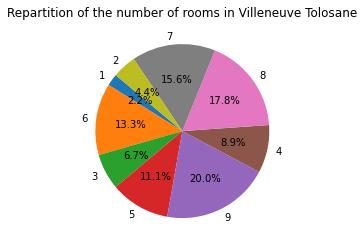

In [41]:
# Repartition of the number of rooms in Villeneuve Tolosane

#Running Query
df1 = spark.sql("SELECT * from real_estate").toPandas()
df2 = spark.sql("SELECT NbRooms FROM real_estate WHERE City='VILLENEUVE TOLOSANE' GROUP BY NbRooms").toPandas()

#Creating Visualization
fig = plt.pie(df2['NbRooms'], autopct='%1.1f%%', startangle=140,labels=df2['NbRooms'])
plt.title('Repartition of the number of rooms in Villeneuve Tolosane')
plt.show()

#https://towardsdatascience.com/complete-introduction-to-pyspark-part-4-62a99ce3552a

(array([2.5386e+04, 3.3494e+04, 6.7680e+03, 4.8700e+02, 5.4000e+01,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41]),
 <BarContainer object of 20 artists>)

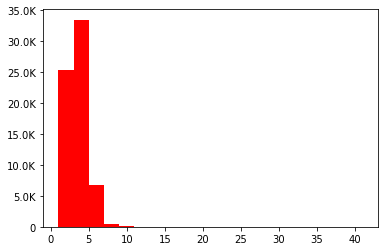

In [42]:
# Repartition of the number of rooms in Toulouse and its suburbs
fig, ax = plt.subplots()
hist(ax, clean_real_estate_df.select('NbRooms'), bins = 20, color=['red'])

(array([1.3963e+04, 0.0000e+00, 3.4065e+04, 0.0000e+00, 1.5630e+04,
        0.0000e+00, 2.1630e+03, 0.0000e+00, 3.0800e+02, 0.0000e+00,
        0.0000e+00, 3.7000e+01, 0.0000e+00, 1.7000e+01, 0.0000e+00,
        6.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ,
        4.95, 5.4 , 5.85, 6.3 , 6.75, 7.2 , 7.65, 8.1 , 8.55, 9.  ]),
 <BarContainer object of 20 artists>)

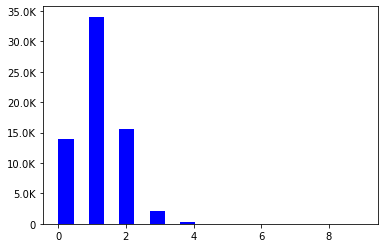

In [43]:
# Repartition of the number of lots in Toulouse and its suburbs 
fig, ax = plt.subplots()
hist(ax, clean_real_estate_df.select('NbLots'), bins = 20, color=['blue'])

In [44]:
#Top selling cities
print('Top selling cities:')

real_estate_cities_df = real_estate_df.groupBy('city')\
                                               .agg({'price':'sum'})\
                                               .withColumnRenamed('sum(price)','total_price')\
                                                .orderBy(['total_price'], ascending=[False])
real_estate_cities_df.show(3)

# Bottom selling cities
print('Bottom selling cities:')

real_estate_cities_df = real_estate_df.groupBy('city')\
                                               .agg({'price':'sum'})\
                                               .withColumnRenamed('sum(price)','total_price')\
                                                .orderBy(['total_price'], ascending=[True])
real_estate_cities_df.show(3)

Top selling cities:
+--------+-----------+
|    city|total_price|
+--------+-----------+
|TOULOUSE|31724699371|
| BLAGNAC| 2524100608|
| CUGNAUX| 1006232069|
+--------+-----------+
only showing top 3 rows

Bottom selling cities:
+------------------+-----------+
|              city|total_price|
+------------------+-----------+
|            LABEGE|   41627819|
|AUZEVILLE-TOLOSANE|   56654539|
|  VIEILLE TOULOUSE|   63845768|
+------------------+-----------+
only showing top 3 rows



In [45]:
# distribution of type of residence
real_estate_residence_type_df = real_estate_df.groupBy('ResidenceType')\
                                 .agg({'ResidenceType':'count'})\
                                 
                                 

real_estate_residence_type_df.show()

+-------------+--------------------+
|ResidenceType|count(ResidenceType)|
+-------------+--------------------+
|        HOUSE|               17630|
|    APARTMENT|               62488|
+-------------+--------------------+



**Observation:** We notice that Toulouse and its suburbs are mostly made up of apartments

In [46]:
# distribution of type of sale type
real_estate_sale_type_df = real_estate_df.groupBy('SaleType')\
                                 .agg({'SaleType':'count'})\
                                 
                                 

real_estate_sale_type_df.show()

+--------------------+---------------+
|            SaleType|count(SaleType)|
+--------------------+---------------+
|SALE BEFORE COMPL...|          13430|
|                SALE|          66688|
+--------------------+---------------+



**Observation:** There is more "Sale" than "Sale before completion" in Toulouse and its suburbs

**Conclusion:**
* We have noticed that there are more apartments sold than houses and that the majority of apartments have less than 5 bedrooms.
* The three cities where accommodation is the cheapest are in the suburbs: AUCAMVILLE, MURET, TOULOUSE and the three cities where housing is the most expensive are:  VIEILLE TOULOUSE, LABEGE, AUZEVILLE TOLOSANE (whithout considerate the type of residence)
* But regarding appartments, in VIEILLE TOULOUSE there are sold at the highest price (11.000€/m²), although this city sells the lower number of apartments (i.e. 2 apartments). Indeed the inhabitants of this city are more likely to buy houses there, that may be why the apartments are sold with an expennsive price, in order for the real estate companies to make profit.
* In the contrary, the less expensive residences are located in AUCAMVILLE (2354€/m² for apartments and 2582€/m² for houses), although they are sold in high volume  compared to other cities (610 apartments and 300 houses.) 
* TOULOUSE is the city with the highest number of sales in our dataset (38347 apartments and 4859 houses sold).
* Finally, unsurprisingly, the city where the volume of sales is the highest is the agglomeration: Toulouse, followed by Blagnac and Cugnaux.